In [1]:

from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.config = args
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/GSE176078mix/GSE176078mix
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/GSE176078mix/GSE176078mix


In [2]:
model = np.load(sample_out+'_dcnmf.npz')

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


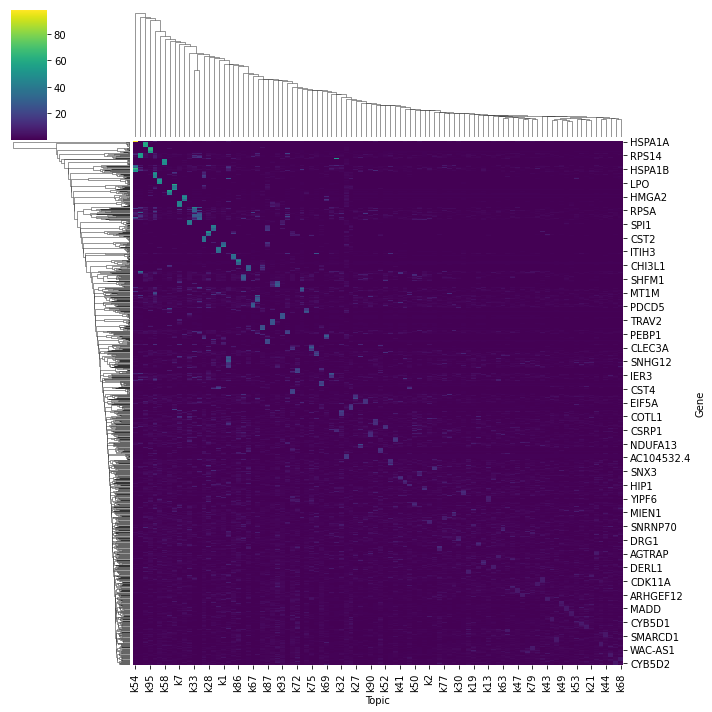

In [3]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [6]:
from sklearn.cluster import KMeans
import umap
from sklearn.preprocessing import StandardScaler

df_theta = pd.DataFrame(model['corr'])
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=100, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_
df_umap['cell_type'] = [x.split('_')[1] for x in df_umap['cell']]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_bulk,cell_type,umap1,umap2
0,CID3586_AAGACCTCAGCATGAG_GSE176078,85,AAGACCTCAGCATGAG,0.631949,18.264603
1,CID3586_AAGGTTCGTAGTACCT_GSE176078,85,AAGGTTCGTAGTACCT,0.714594,17.974279
2,CID3586_ACCAGTAGTTGTGGCC_GSE176078,70,ACCAGTAGTTGTGGCC,0.761479,17.955477
3,CID3586_ACCCACTAGATGTCGG_GSE176078,85,ACCCACTAGATGTCGG,0.742424,17.794930
4,CID3586_ACTGATGGTCAACTGT_GSE176078,78,ACTGATGGTCAACTGT,1.276345,18.157015
...,...,...,...,...,...
155908,TTTGTTGCAGAGGAAA-1_GSM5022606_D11_GSE164898,18,GSM5022606,10.786382,11.694976
155909,TTTGTTGCATGCCATA-1_GSM5022606_D11_GSE164898,18,GSM5022606,11.259567,12.066160
155910,TTTGTTGCATTGCCTC-1_GSM5022606_D11_GSE164898,86,GSM5022606,15.551747,1.788820
155911,TTTGTTGGTTGCATCA-1_GSM5022606_D11_GSE164898,45,GSM5022606,-0.456554,13.058481


In [38]:
# df_umap.to_csv(sample_out+'_umap.csv.gz',index=False, compression='gzip')
df_umap = pd.read_csv(sample_out+'_umap.csv.gz')
df_umap


,cell,topic_bulk,cell_type,umap1,umap2
0,CID3586_AAGACCTCAGCATGAG_GSE176078,85,AAGACCTCAGCATGAG,0.631949,18.264603
1,CID3586_AAGGTTCGTAGTACCT_GSE176078,85,AAGGTTCGTAGTACCT,0.714594,17.974280
2,CID3586_ACCAGTAGTTGTGGCC_GSE176078,70,ACCAGTAGTTGTGGCC,0.761479,17.955477
3,CID3586_ACCCACTAGATGTCGG_GSE176078,85,ACCCACTAGATGTCGG,0.742424,17.794930
4,CID3586_ACTGATGGTCAACTGT_GSE176078,78,ACTGATGGTCAACTGT,1.276344,18.157015
...,...,...,...,...,...
155908,TTTGTTGCAGAGGAAA-1_GSM5022606_D11_GSE164898,18,GSM5022606,10.786382,11.694976
155909,TTTGTTGCATGCCATA-1_GSM5022606_D11_GSE164898,18,GSM5022606,11.259567,12.066160
155910,TTTGTTGCATTGCCTC-1_GSM5022606_D11_GSE164898,86,GSM5022606,15.551747,1.788820
155911,TTTGTTGGTTGCATCA-1_GSM5022606_D11_GSE164898,45,GSM5022606,-0.456554,13.058481


Text(0, 0.5, 'UMAP2')

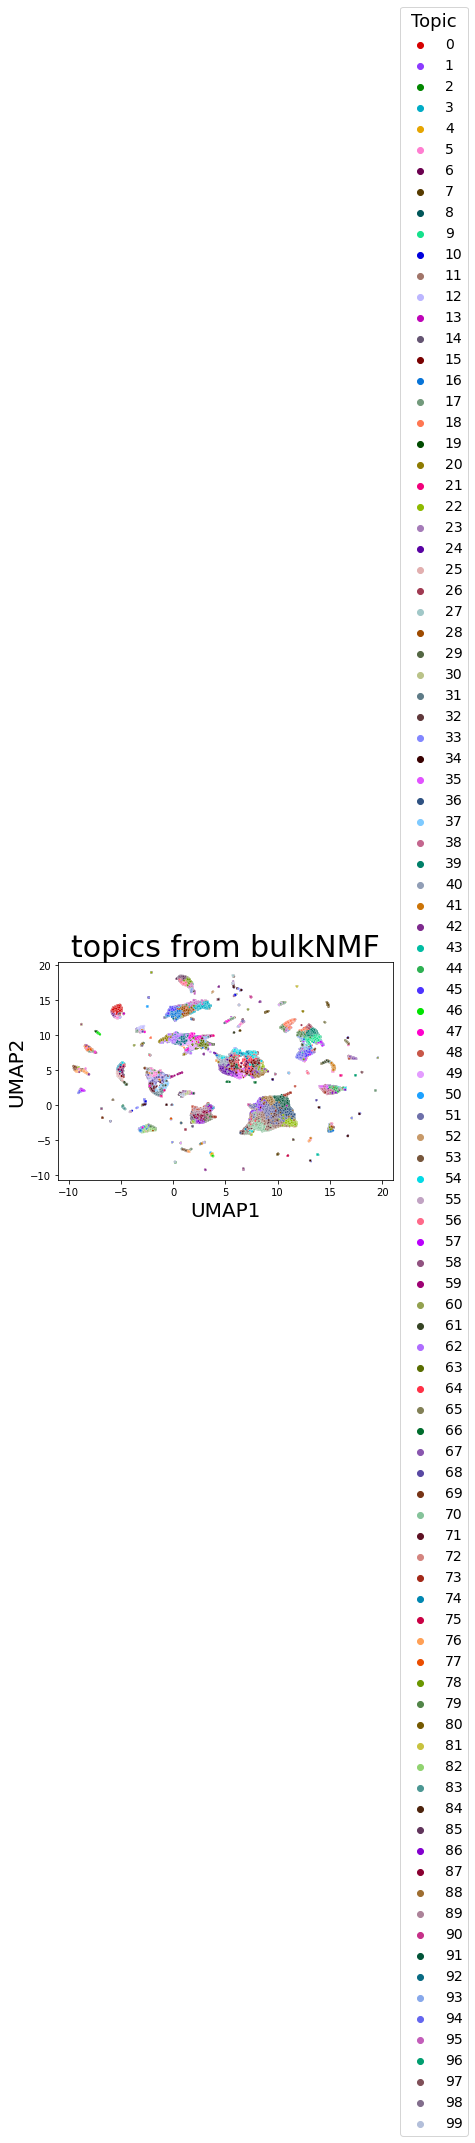

In [25]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

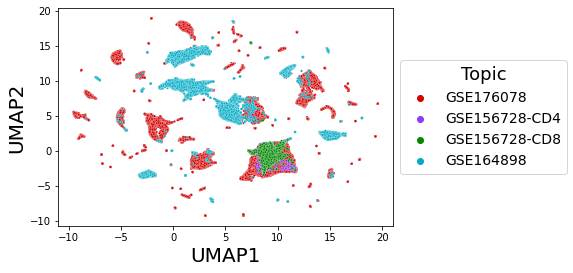

In [39]:
df_umap['dataset'] = [x.split('_')[len(x.split('_'))-1] for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['dataset'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='dataset',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

In [41]:
df_pl = pd.read_csv('/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/GSE176078mix/GSE176078_metadata.csv.gz')
df_pl
df_pl = df_pl.loc[:,['Unnamed: 0','celltype_major']]
df_pl.columns = ['cell','cell_type']
df_pl

,cell,cell_type
0,CID3586_AAGACCTCAGCATGAG,Endothelial
1,CID3586_AAGGTTCGTAGTACCT,Endothelial
2,CID3586_ACCAGTAGTTGTGGCC,Endothelial
3,CID3586_ACCCACTAGATGTCGG,Endothelial
4,CID3586_ACTGATGGTCAACTGT,Endothelial
...,...,...
100059,CID4398_TCAGGTAGTACTCAAC,Myeloid
100060,CID4398_TCTATTGTCGCCATAA,Myeloid
100061,CID4398_TCTTTCCCAGTAAGCG,Myeloid
100062,CID4398_TGCCCATGTTACGGAG,Myeloid


In [42]:
df_umap=df_umap[df_umap['dataset']=='GSE176078']
df_umap['cell'] = [x.split('_')[0] + '_' +x.split('_')[1] for x in df_umap['cell']]
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap


<ipython-input-42-230bd35e1dd1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_umap['cell'] = [x.split('_')[0] + '_' +x.split('_')[1] for x in df_umap['cell']]


,cell,topic_bulk,cell_type_x,umap1,umap2,dataset,cell_type_y
0,CID3586_AAGACCTCAGCATGAG,85,AAGACCTCAGCATGAG,0.631949,18.264603,GSE176078,Endothelial
1,CID3586_AAGGTTCGTAGTACCT,85,AAGGTTCGTAGTACCT,0.714594,17.974280,GSE176078,Endothelial
2,CID3586_ACCAGTAGTTGTGGCC,70,ACCAGTAGTTGTGGCC,0.761479,17.955477,GSE176078,Endothelial
3,CID3586_ACCCACTAGATGTCGG,85,ACCCACTAGATGTCGG,0.742424,17.794930,GSE176078,Endothelial
4,CID3586_ACTGATGGTCAACTGT,78,ACTGATGGTCAACTGT,1.276344,18.157015,GSE176078,Endothelial
...,...,...,...,...,...,...,...
100059,CID4398_TCAGGTAGTACTCAAC,74,TCAGGTAGTACTCAAC,3.723712,-0.449180,GSE176078,Myeloid
100060,CID4398_TCTATTGTCGCCATAA,43,TCTATTGTCGCCATAA,-5.032595,3.803960,GSE176078,Myeloid
100061,CID4398_TCTTTCCCAGTAAGCG,6,TCTTTCCCAGTAAGCG,-5.128755,4.479215,GSE176078,Myeloid
100062,CID4398_TGCCCATGTTACGGAG,25,TGCCCATGTTACGGAG,-5.056932,3.858716,GSE176078,Myeloid


Text(0, 0.5, 'UMAP2')

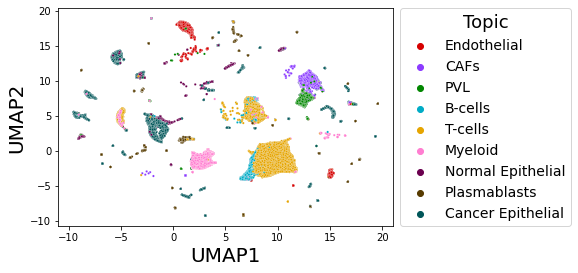

In [44]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type_y'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type_y',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

In [46]:
df_match = df_umap[['cell','cell_type_y','topic_bulk']]
df_match = df_match.groupby(['cell_type_y','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type_y','topic_bulk')
df_match = df_match.fillna(0)
df_match


cell                                                    \
topic_bulk             0       1     2     3       5       6     8       9    
cell_type_y                                                                   
B-cells               0.0   112.0   0.0   0.0     0.0    23.0   0.0     0.0   
CAFs                  0.0     0.0   0.0   0.0     1.0     1.0   1.0  2009.0   
Cancer Epithelial  2879.0     0.0   0.0   0.0  2187.0     0.0   0.0    34.0   
Endothelial           1.0     0.0   0.0  38.0     1.0     2.0   0.0     5.0   
Myeloid               0.0    17.0   0.0   0.0     2.0    74.0   0.0     0.0   
Normal Epithelial     3.0     0.0   0.0   0.0   411.0     0.0   0.0     3.0   
PVL                   0.0     0.0   0.0   2.0     0.0     0.0   0.0   103.0   
Plasmablasts          0.0     3.0  49.0   0.0     1.0     3.0  80.0     1.0   
T-cells               0.0  2708.0   0.0   0.0    57.0  1323.0   0.0     3.0   

                                  ...                                    \
topic_bulk            10      11  ...      89   90      91    92     93   
cell_type_y                       ...                                     
B-cells              3.0   374.0  ...    10.0  0.0     4.0   0.0    0.0   
CAFs                 0.0     0.0  ...     0.0  0.0     1.0   0.0  169.0   
Cancer Epithelial    0.0     3.0  ...     0.0  0.0     0.0   9.0    5.0   
Endothelial          0.0     0.0  ...     0.0  0.0     1.0   0.0  363.0   
Myeloid              0.0   112.0  ...  1421.0  0.0     9.0   0.0    7.0   
Normal Epithelial    0.0     0.0  ...     0.0  0.0     0.0  15.0    8.0   
PVL                  0.0     0.0  ...     0.0  0.0     0.0   0.0  413.0   
Plasmablasts       374.0     1.0  ...     1.0  0.0     3.0   0.0    0.0   
T-cells              1.0  5119.0  ...     1.0  3.0  1618.0   0.0    1.0   

                                                     
topic_bulk             94     95    96    98     99  
cell_type_y                                          
B-cells               0.0    0.0   0.0   0.0    4.0  
CAFs                 23.0   49.0   0.0   2.0    1.0  
Cancer Epithelial    14.0    3.0   0.0   0.0    2.0  
Endothelial          15.0  351.0   0.0   1.0    0.0  
Myeloid               0.0    0.0   0.0   0.0    0.0  
Normal Epithelial   135.0    5.0   0.0   0.0    1.0  
PVL                2253.0   44.0   0.0   0.0    0.0  
Plasmablasts          0.0    0.0  83.0  50.0  336.0  
T-cells               0.0    0.0   0.0   6.0    8.0  

[9 rows x 95 columns]

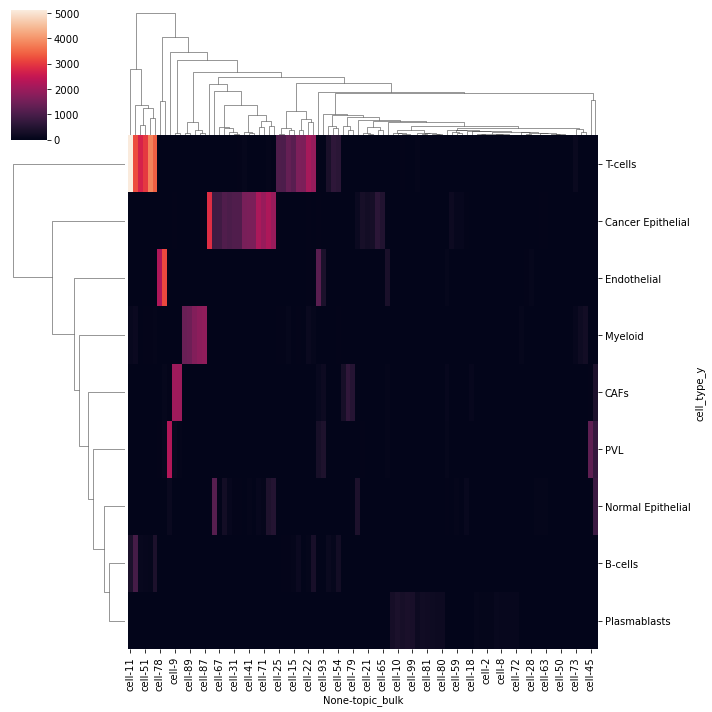

In [47]:
sns.clustermap(df_match)

In [48]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type_y'].values,df_umap['topic_bulk'].values)

0.5110439851143014